# Project Overview
This project successfully developed an image classification model using a fine-tuned EfficientNet-B0 to distinguish between AI-generated and real images. The process involved loading and exploring the dataset, applying robust data preprocessing and augmentation techniques, modifying a pre-trained model for binary classification, and training the model using a two-stage fine-tuning approach with early stopping and learning rate scheduling to optimize performance and prevent overfitting.

In [1]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("cashbowman/ai-generated-images-vs-real-images")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/ai-generated-images-vs-real-images


In [2]:
pip install torchmetrics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 983.0/983.0 kB 42.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 64.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 33.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 47.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 10.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 8.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 188.7/188.7 MB 6.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 94.9 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-c

In [3]:
# Importing necessary libraries

import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models, datasets, transforms
from torch.utils.data import DataLoader, random_split , Dataset
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torchmetrics.classification import BinaryAccuracy
from PIL import Image
from sklearn.model_selection import train_test_split
from collections import Counter
import pandas as pd

In [4]:
# Visualization library
import matplotlib.pyplot as plt
import seaborn as sns

In [5]:
# Metrics
from sklearn.metrics import confusion_matrix

# Suppressing warnings
from warnings import filterwarnings
filterwarnings('ignore')

In [6]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

# Data Loading and Exploration

The dataset was downloaded using the KaggleHub library. The path to the dataset files was then defined. We loaded the dataset using `torchvision.datasets.ImageFolder`, which automatically infers the class labels from the folder structure. We then extracted the images and labels and used the `Counter` to see the distribution of the two classes (AI-generated and real). Finally, a sample image was visualized along with its label to get a visual understanding of the data. This initial exploration confirmed the presence of two distinct classes and provided a sense of the image content.

In [7]:
# Define the path to the dataset
path = '/kaggle/input/ai-generated-images-vs-real-images'

In [8]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

# Define the path to your dataset
path = path
img_size = 28
transform = transforms.Compose([
    transforms.Resize((img_size,img_size)),  # Resize the images to a fixed size
    transforms.ToTensor()  # Convert images to PyTorch tensors
])
# Load the dataset
data = datasets.ImageFolder(root=path, transform=transform)

# # Define batch size
# batch_size = 32

# # Create DataLoader
# data_loader = DataLoader(data, batch_size=batch_size, shuffle=True)

# # Iterate through the DataLoader
# for batch_images, batch_labels in data_loader:
#     # Print the shape of the batch of images
#     print("Batch images shape:", batch_images.shape)
#     # Print the shape of the batch of labels
#     print("Batch labels shape:", batch_labels.shape)

In [9]:
# Create an ImageFolder object
data = datasets.ImageFolder(root=path)

# Extract labels from the dataset
images, labels = zip(*data.samples)

# Count the occurrences of each label
label_counts = Counter(labels)

# Print the label counts
print("Label Counts:")
for label, count in label_counts.items():
    print(f"Label {label}: {count} samples")

Label Counts:
Label 0: 539 samples
Label 1: 434 samples


Tensor image shape: torch.Size([3, 256, 256])


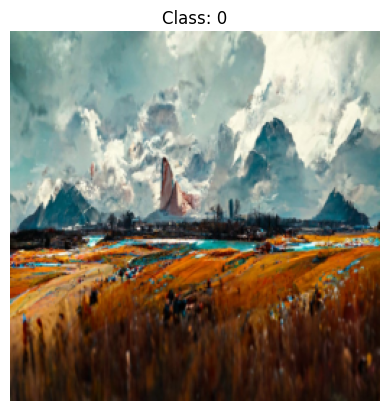

In [18]:
import matplotlib.pyplot as plt
from torchvision import datasets, transforms

# Define path to your image folder
path = path
img_size = 256

# Define transformations to apply to the images
transform = transforms.Compose([
    transforms.Resize((img_size,img_size)),  # Resize the images to a fixed size
    transforms.ToTensor()  # Convert images to PyTorch tensors
])

# Create an ImageFolder object
data = datasets.ImageFolder(root=path, transform=transform)

# Select an image index to display
image_index = 69

# Access an image and its corresponding label
image, label = data[image_index]

# Print the shape of the tensor image
print("Tensor image shape:", image.shape)

# Convert the tensor image to a PIL image
image_pil = transforms.ToPILImage()(image)

# Display the image along with its label
plt.imshow(image_pil)
plt.title(f"Class: {label}")
plt.axis('off')
plt.show()

In [11]:
# Create an ImageFolder object
data = datasets.ImageFolder(root=path) # , transform=transform

# Extract labels from the dataset
images, labels = zip(*data.samples)

# Perform stratified splitting
train_images, test_images, train_labels, test_labels = train_test_split(images, labels,
                                                                        test_size=0.2,
                                                                        stratify=labels)

In [12]:
# Zip train images with train labels and create DataFrame
train_data_df = pd.DataFrame({'images': train_images, 'labels': train_labels})

# Zip test images with test labels and create DataFrame
test_data_df = pd.DataFrame({'images': test_images, 'labels': test_labels})


class CustomImageDataset(Dataset):
    def __init__(self, dataframe, transform=None):
        self.dataframe = dataframe
        self.transform = transform

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        img_name = self.dataframe.iloc[idx, 0]
        image = Image.open(img_name)

        # Convert image to tensor
        image = self.transform(image)

        # Ensure image has three channels (RGB)
        if image.shape[0] == 1:  # If grayscale, convert to RGB
            image = image.expand(3, -1, -1)  # Expand grayscale to three channels
        elif image.shape[0] == 4:  # If RGBA, remove alpha channel
            image = image[:3]  # Remove alpha channel

        label = self.dataframe.iloc[idx, 1]

        return image, label

In [19]:
from torchvision import transforms
from PIL import Image

img_size = 224

# Updated train transform with RGB conversion
train_transform = transforms.Compose([
    transforms.Lambda(lambda x: x.convert('RGB')),  # Convert to RGB
    transforms.Resize((img_size, img_size)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.1, hue=0.1),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Updated test transform with RGB conversion
test_transform = transforms.Compose([
    transforms.Lambda(lambda x: x.convert('RGB')),  # Convert to RGB
    transforms.Resize((img_size, img_size)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Create custom datasets for train and test sets
train_dataset = CustomImageDataset(train_data_df, transform=train_transform)
test_dataset = CustomImageDataset(test_data_df, transform=test_transform)

# Print samples to verify
print("Train Dataset:")
for i in range(5):  # Print the first 5 samples
    sample = train_dataset[i]
    print("Sample", i+1, " - Image shape:", sample[0].shape, " - Label:", sample[1])

print("\nTest Dataset:")
for i in range(5):  # Print the first 5 samples
    sample = test_dataset[i]
    print("Sample", i+1, " - Image shape:", sample[0].shape, " - Label:", sample[1])

Train Dataset:
Sample 1  - Image shape: torch.Size([3, 224, 224])  - Label: 1
Sample 2  - Image shape: torch.Size([3, 224, 224])  - Label: 1
Sample 3  - Image shape: torch.Size([3, 224, 224])  - Label: 0
Sample 4  - Image shape: torch.Size([3, 224, 224])  - Label: 0
Sample 5  - Image shape: torch.Size([3, 224, 224])  - Label: 0

Test Dataset:
Sample 1  - Image shape: torch.Size([3, 224, 224])  - Label: 1
Sample 2  - Image shape: torch.Size([3, 224, 224])  - Label: 0
Sample 3  - Image shape: torch.Size([3, 224, 224])  - Label: 0
Sample 4  - Image shape: torch.Size([3, 224, 224])  - Label: 1
Sample 5  - Image shape: torch.Size([3, 224, 224])  - Label: 0


In [26]:
train_dataset[0][0].shape , train_dataset[0][1]

(torch.Size([3, 224, 224]), np.int64(1))

Text(0.5, 1.0, '1')

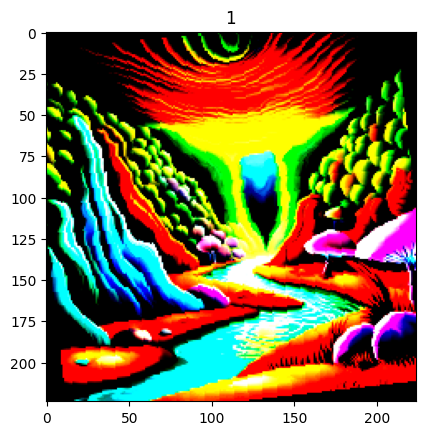

In [27]:
plt.imshow(train_dataset[4][0].permute(1,2,0))
plt.title(train_dataset[0][1])

In [28]:
print("Train Dataset:")
for i in range(5):  # Print the first 5 samples
    sample = train_dataset[i]
    print("Sample", i+1, " - Image shape:", sample[0].shape, " - Label:", sample[1])

# Print samples from test dataset
print("\nTest Dataset:")
for i in range(5):  # Print the first 5 samples
    sample = test_dataset[i]
    print("Sample", i+1, " - Image shape:", sample[0].shape, " - Label:", sample[1])

Train Dataset:
Sample 1  - Image shape: torch.Size([3, 224, 224])  - Label: 1
Sample 2  - Image shape: torch.Size([3, 224, 224])  - Label: 1
Sample 3  - Image shape: torch.Size([3, 224, 224])  - Label: 0
Sample 4  - Image shape: torch.Size([3, 224, 224])  - Label: 0
Sample 5  - Image shape: torch.Size([3, 224, 224])  - Label: 0

Test Dataset:
Sample 1  - Image shape: torch.Size([3, 224, 224])  - Label: 1
Sample 2  - Image shape: torch.Size([3, 224, 224])  - Label: 0
Sample 3  - Image shape: torch.Size([3, 224, 224])  - Label: 0
Sample 4  - Image shape: torch.Size([3, 224, 224])  - Label: 1
Sample 5  - Image shape: torch.Size([3, 224, 224])  - Label: 0


In [29]:
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32)

In [30]:
num_train_batches = len(train_loader)

# Calculate the number of batches in test_loader
num_test_batches = len(test_loader)

# Print the counts
print("Number of batches in train_loader:", num_train_batches)
print("Number of batches in test_loader:", num_test_batches)

Number of batches in train_loader: 25
Number of batches in test_loader: 7


# Data Preprocessing and Augmentation

To prepare the images for the neural network, several transformations were applied. Images were resized to a fixed size (224x224) using `transforms.Resize`. They were then converted to PyTorch tensors using `transforms.ToTensor()`. For the training set, data augmentation techniques such as random horizontal flips, random rotations, and color jitter were applied to increase the diversity of the training data and help the model generalize better. Finally, all images were normalized using the standard mean and standard deviation for pre-trained ImageNet models. A custom `Dataset` class was created to handle loading images and applying these transformations from the dataframe containing file paths and labels. The transformations were visualized to show their effect on the images.

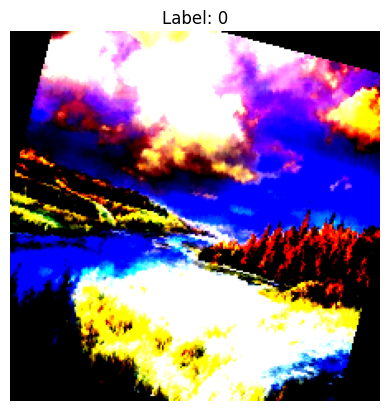

In [31]:
i, f = next(iter(train_loader))

# Extracting the first image from the batch
image = i[0]
label = f[0]

# Plotting the image
plt.imshow(image.permute(1, 2, 0))  # Permute to (H, W, C) for displaying with matplotlib
plt.title(f"Label: {label}")
plt.axis('off')
plt.show()


--- Visualizing Data Augmentation ---


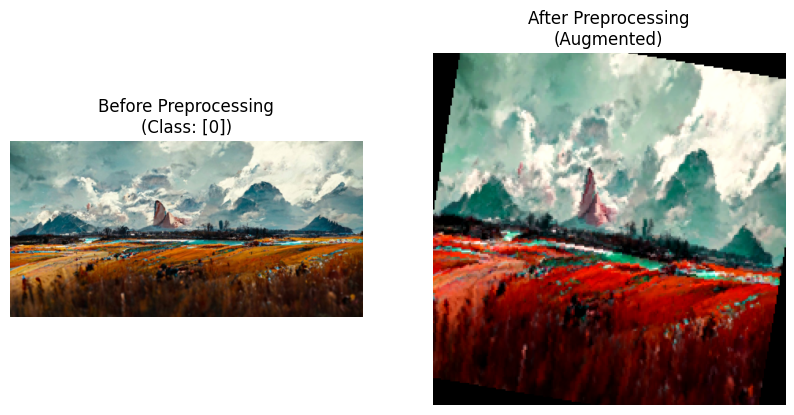

In [32]:
# =============================================================================
# 3. Visuals Before and After Preprocessing
# =============================================================================
# This section visualizes the effect of the data augmentation transforms.

print("\n--- Visualizing Data Augmentation ---")

def imshow(tensor, title=None):
    """Helper function to un-normalize and display a tensor image."""
    image = tensor.cpu().clone()  # We don't want to modify the original tensor
    image = image.squeeze(0)
    # Un-normalize
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    image = image.permute(1, 2, 0) * torch.tensor(std) + torch.tensor(mean)
    image = image.numpy().clip(0, 1)
    plt.imshow(image)
    if title is not None:
        plt.title(title)
    plt.axis('off')

# Get a sample image from the dataset *before* augmentation
# We need a dataset instance without the aggressive transforms for this
plain_transform = transforms.Compose([
    transforms.Lambda(lambda x: x.convert('RGB')),
    transforms.Resize(img_size)
])
vis_dataset = datasets.ImageFolder(root=path, transform=plain_transform)
original_pil_image, label = vis_dataset[69] # Get the 69th image as an example

# Get the same image with augmentation applied
augmented_tensor = train_transform(original_pil_image)

# Plot side-by-side
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(original_pil_image)
plt.title(f"Before Preprocessing\n(Class: {[label]})")
plt.axis('off')

plt.subplot(1, 2, 2)
# The augmented tensor needs to be converted back for visualization
imshow(augmented_tensor.unsqueeze(0), title="After Preprocessing\n(Augmented)")
plt.show()

In [33]:
for batch_idx, (images, labels) in enumerate(train_loader):
    print(f"Batch {batch_idx + 1}: {images.shape}")

Batch 1: torch.Size([32, 3, 224, 224])
Batch 2: torch.Size([32, 3, 224, 224])
Batch 3: torch.Size([32, 3, 224, 224])
Batch 4: torch.Size([32, 3, 224, 224])
Batch 5: torch.Size([32, 3, 224, 224])
Batch 6: torch.Size([32, 3, 224, 224])
Batch 7: torch.Size([32, 3, 224, 224])
Batch 8: torch.Size([32, 3, 224, 224])
Batch 9: torch.Size([32, 3, 224, 224])
Batch 10: torch.Size([32, 3, 224, 224])
Batch 11: torch.Size([32, 3, 224, 224])
Batch 12: torch.Size([32, 3, 224, 224])
Batch 13: torch.Size([32, 3, 224, 224])
Batch 14: torch.Size([32, 3, 224, 224])
Batch 15: torch.Size([32, 3, 224, 224])
Batch 16: torch.Size([32, 3, 224, 224])
Batch 17: torch.Size([32, 3, 224, 224])
Batch 18: torch.Size([32, 3, 224, 224])
Batch 19: torch.Size([32, 3, 224, 224])
Batch 20: torch.Size([32, 3, 224, 224])
Batch 21: torch.Size([32, 3, 224, 224])
Batch 22: torch.Size([32, 3, 224, 224])
Batch 23: torch.Size([32, 3, 224, 224])
Batch 24: torch.Size([32, 3, 224, 224])
Batch 25: torch.Size([10, 3, 224, 224])


In [34]:
for batch_idx, (images, labels) in enumerate(test_loader):
    print(f"Batch {batch_idx + 1}: {images.shape}")

Batch 1: torch.Size([32, 3, 224, 224])
Batch 2: torch.Size([32, 3, 224, 224])
Batch 3: torch.Size([32, 3, 224, 224])
Batch 4: torch.Size([32, 3, 224, 224])
Batch 5: torch.Size([32, 3, 224, 224])
Batch 6: torch.Size([32, 3, 224, 224])
Batch 7: torch.Size([3, 3, 224, 224])


# Model Definition and Modification

A pre-trained EfficientNet-B0 model from `torchvision.models` was used as the base model. This model was chosen because it provides a good balance of performance and computational efficiency. Since the original EfficientNet-B0 is trained for 1000 classes, the final classifier layer was modified to output a single value, suitable for binary classification. This was achieved by replacing the original linear layer with a new `nn.Linear` layer with `out_features=1`. The `torchinfo.summary` was used to inspect the model architecture and confirm the changes, showing the number of parameters and the output shape.

In [35]:
# Using a pre-trained EfficientNet-B0 model, which is smaller and less prone to overfitting
model = models.efficientnet_b0(weights = 'DEFAULT')

Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-7f5810bc.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-7f5810bc.pth
100%|██████████| 20.5M/20.5M [00:00<00:00, 160MB/s]


In [36]:
!pip install torchinfo -q

In [37]:
from torchinfo import summary
# We visualize our neural network before freezing the extractor layers..
summary(model, input_size = [1,3,112,112],
        col_names = ["input_size", "output_size", "num_params", "trainable"],
       col_width = 18,
       row_settings=["var_names"])

Layer (type (var_name))                                      Input Shape        Output Shape       Param #            Trainable
EfficientNet (EfficientNet)                                  [1, 3, 112, 112]   [1, 1000]          --                 True
├─Sequential (features)                                      [1, 3, 112, 112]   [1, 1280, 4, 4]    --                 True
│    └─Conv2dNormActivation (0)                              [1, 3, 112, 112]   [1, 32, 56, 56]    --                 True
│    │    └─Conv2d (0)                                       [1, 3, 112, 112]   [1, 32, 56, 56]    864                True
│    │    └─BatchNorm2d (1)                                  [1, 32, 56, 56]    [1, 32, 56, 56]    64                 True
│    │    └─SiLU (2)                                         [1, 32, 56, 56]    [1, 32, 56, 56]    --                 --
│    └─Sequential (1)                                        [1, 32, 56, 56]    [1, 16, 56, 56]    --                 True
│    │    └─M

In [38]:
# Modifying final classifier layer
model.classifier[1] = nn.Linear(model.classifier[1].in_features, 1)

In [39]:
summary(model, input_size = [1,3,112,112],
        col_names = ["input_size", "output_size", "num_params", "trainable"],
       col_width = 18,
       row_settings=["var_names"])

Layer (type (var_name))                                      Input Shape        Output Shape       Param #            Trainable
EfficientNet (EfficientNet)                                  [1, 3, 112, 112]   [1, 1]             --                 True
├─Sequential (features)                                      [1, 3, 112, 112]   [1, 1280, 4, 4]    --                 True
│    └─Conv2dNormActivation (0)                              [1, 3, 112, 112]   [1, 32, 56, 56]    --                 True
│    │    └─Conv2d (0)                                       [1, 3, 112, 112]   [1, 32, 56, 56]    864                True
│    │    └─BatchNorm2d (1)                                  [1, 32, 56, 56]    [1, 32, 56, 56]    64                 True
│    │    └─SiLU (2)                                         [1, 32, 56, 56]    [1, 32, 56, 56]    --                 --
│    └─Sequential (1)                                        [1, 32, 56, 56]    [1, 16, 56, 56]    --                 True
│    │    └─M

In [40]:
criterion = nn.BCEWithLogitsLoss()

optimizer = optim.Adam(model.parameters(), lr = 0.001)

In [41]:
import copy

class EarlyStopping:
    def __init__(self, patience=5, min_delta=0, restore_best_weights=True):
        self.patience = patience
        self.min_delta = min_delta
        self.restore_best_weights = restore_best_weights
        self.best_model = None
        self.best_loss = None
        self.best_accuracy = None  # New attribute to track best accuracy
        self.counter = 0
        self.status = ""

    def __call__(self, model, val_loss, val_accuracy):
        if self.best_loss is None or val_loss < self.best_loss:  # Update if val_loss is better
            self.best_loss = val_loss
            self.best_accuracy = val_accuracy  # Update best accuracy along with best loss
            self.best_model = copy.deepcopy(model.state_dict())
            self.counter = 0
            self.status = f"Improvement found, counter reset to {self.counter}. " \
                          # f"Best Loss: {self.best_loss:.4f}, Best Accuracy: {self.best_accuracy:.2f}%"

        elif self.best_loss - val_loss >= self.min_delta:
            self.best_model = copy.deepcopy(model.state_dict())
            self.best_loss = val_loss
            self.counter = 0
            self.status = f"Improvement found, counter reset to {self.counter}. " \
                          # f"Best Loss: {self.best_loss:.4f}, Best Accuracy: {self.best_accuracy:.2f}%"

        else:
            self.counter += 1
            self.status = f"No improvement in the last {self.counter} epochs. " \
                          # f"Best Loss: {self.best_loss:.4f}, Best Accuracy: {self.best_accuracy:.2f}%"
            if self.counter >= self.patience:
                self.status = f"Early stopping triggered after {self.counter} epochs. " \
                              f"Best Loss: {self.best_loss:.4f}, Best Accuracy: {self.best_accuracy:.2f}%"
                if self.restore_best_weights:
                    model.load_state_dict(self.best_model)
                return True
        return False

In [42]:
# Define EarlyStopping
early_stopping = EarlyStopping(patience = 10, min_delta = 0.0)

In [43]:
from tqdm.autonotebook import tqdm

In [44]:
def train_step(model:torch.nn.Module,
               dataloader:torch.utils.data.DataLoader,
               loss_fn:torch.nn.Module,
               optimizer:torch.optim.Optimizer):

    model.train()

    train_loss = 0.
    accuracy_train = BinaryAccuracy(threshold = 0.5).to(device)

    for batch,(X,y) in enumerate(tqdm(dataloader)):
        X,y = X.to(device,dtype=torch.float32), y.to(device,dtype=torch.float32)

        y_pred = model(X).squeeze()
        loss = loss_fn(y_pred, y)
        train_loss += loss.detach().cpu().item()

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        y_proba = torch.sigmoid(y_pred)
        accuracy_train.update(y_proba, y)

    train_accuracy = accuracy_train.compute()
    train_loss = train_loss/len(dataloader)


    return train_loss, train_accuracy

In [45]:
def test_step(model:torch.nn.Module,
              dataloader:torch.utils.data.DataLoader,
              loss_fn:torch.nn.Module):

    model.eval()

    test_loss = 0.
    accuracy_test = BinaryAccuracy(threshold = 0.5).to(device)

    for batch,(X,y) in enumerate(tqdm(dataloader)):
        X,y = X.to(device,dtype=torch.float32), y.to(device,dtype=torch.float32)

        y_pred = model(X).squeeze()

        loss = loss_fn(y_pred, y)
        test_loss += loss.detach().cpu().item()

        y_proba = torch.sigmoid(y_pred)
        accuracy_test.update(y_proba, y)

    test_accuracy = accuracy_test.compute()
    test_loss = test_loss/len(dataloader)

    return test_loss, test_accuracy

In [46]:
def train(model:torch.nn.Module,
          train_dataloader:torch.utils.data.DataLoader,
          test_dataloader:torch.utils.data.DataLoader,
          loss_fn:torch.nn.Module,
          optimizer:torch.optim.Optimizer, # <-- Corrected spelling
          epochs:int):

    best_test_loss = float('inf')

    results = {'train_loss':[],
               'train_accuracy':[],
               'test_loss':[],
               'test_accuracy':[]}

    for epoch in tqdm(range(epochs)):
        train_loss, train_accuracy = train_step(model = model,
                                                dataloader = train_dataloader,
                                                loss_fn = loss_fn,
                                                optimizer = optimizer)

        test_loss, test_accuracy = test_step(model = model,
                                             dataloader = test_dataloader,
                                             loss_fn = loss_fn)



        print(f"Epoch: {epoch+1} | ",
              f"Train Loss: {train_loss:.4f} | ",
              f"Train Accuracy: {train_accuracy:.4f} | ",
              f"Test Loss: {test_loss:.4f} | ",
              f"Test Accuracy: {test_accuracy:.4f}")


        print(early_stopping.status)
        if early_stopping(model,test_loss,test_accuracy):
            print(early_stopping.status)
            print("Early Stopping!!")
            break

        results["train_loss"].append(train_loss)
        results["train_accuracy"].append(train_accuracy.detach().cpu().item())
        results["test_loss"].append(test_loss)
        results["test_accuracy"].append(test_accuracy.detach().cpu().item())

    return results

# Training Process

The training process involved a two-stage fine-tuning approach. In the first stage, the feature extraction layers of the EfficientNet-B0 were frozen (`requires_grad = False`), and only the newly added classifier head was trained. This allows the model to quickly learn how to map the extracted features to the new task. An Adam optimizer with a learning rate of 0.001 was used for this stage.

In the second stage, all layers of the model were unfrozen (`requires_grad = True`), allowing the entire network to be fine-tuned on the dataset. A lower learning rate (1e-4) and weight decay were used for the Adam optimizer in this stage to prevent drastic changes to the pre-trained weights and improve regularization. A `ReduceLROnPlateau` learning rate scheduler was also incorporated to reduce the learning rate if the validation loss plateaued, helping the model converge better. An `EarlyStopping` mechanism was implemented to monitor the validation loss and stop the training process if no significant improvement was observed for a certain number of epochs, preventing overfitting and saving computation time. The training and testing steps were defined as functions to handle forward and backward passes, loss calculation, and accuracy computation.

In [57]:
# Set seed for reproducibility
SEED = 42
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)

# --- IMPROVEMENT: TWO-STAGE FINE-TUNING ---

# STAGE 1: Freeze feature layers and train only the classifier head
print("--- STAGE 1: Training the classifier head ---")
# Freeze all the layers in the 'features' section of the model
for param in model.features.parameters():
    param.requires_grad = False

# Define a new optimizer for ONLY the classifier's parameters
optimizer_stage1 = optim.Adam(model.classifier.parameters(), lr=0.001)

# Train for 5 epochs
for epoch in range(5):
    train_loss, train_acc = train_step(model, train_loader, criterion, optimizer_stage1)
    test_loss, test_acc = test_step(model, test_loader, criterion)
    print(f"[Stage 1] Epoch: {epoch+1} | Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f} | Test Loss: {test_loss:.4f} | Test Acc: {test_acc:.4f}")


--- STAGE 1: Training the classifier head ---


  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

[Stage 1] Epoch: 1 | Train Loss: 0.2120 | Train Acc: 0.9280 | Test Loss: 0.1388 | Test Acc: 0.9538


  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

[Stage 1] Epoch: 2 | Train Loss: 0.2218 | Train Acc: 0.9177 | Test Loss: 0.1301 | Test Acc: 0.9487


  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

[Stage 1] Epoch: 3 | Train Loss: 0.2173 | Train Acc: 0.9165 | Test Loss: 0.1275 | Test Acc: 0.9590


  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

[Stage 1] Epoch: 4 | Train Loss: 0.2140 | Train Acc: 0.9216 | Test Loss: 0.1226 | Test Acc: 0.9538


  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

[Stage 1] Epoch: 5 | Train Loss: 0.1932 | Train Acc: 0.9332 | Test Loss: 0.1235 | Test Acc: 0.9538


In [58]:
# STAGE 2: Unfreeze all layers and fine-tune the entire model
print("\n--- STAGE 2: Fine-tuning the entire model ---")
# Unfreeze all model parameters
for param in model.parameters():
    param.requires_grad = True

# IMPROVEMENT: Use a lower learning rate and add weight decay for regularization
optimizer_stage2 = optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-4)

# IMPROVEMENT: Use a learning rate scheduler to adjust LR on performance plateaus
scheduler = ReduceLROnPlateau(optimizer_stage2, mode='min', factor=0.2, patience=3, verbose=True)

# Re-initialize Early Stopping for the main training phase
early_stopping = EarlyStopping(patience=8, min_delta=0.001)


--- STAGE 2: Fine-tuning the entire model ---


In [59]:
# Run the main training loop
EPOCHS = 50 # We can use fewer epochs as early stopping will likely trigger
MODEL_RESULTS = train(model=model,
                      train_dataloader=train_loader,
                      test_dataloader=test_loader,
                      loss_fn=criterion,
                      optimizer=optimizer_stage2, # Use the new optimizer
                      epochs=EPOCHS)

# Add the scheduler step inside your 'train' function or create a new loop
# For simplicity, here's how you'd modify the main 'train' function from cell [38]:
# At the end of the for loop, just before checking for early stopping, add:
# scheduler.step(test_loss)

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch: 1 |  Train Loss: 0.2048 |  Train Accuracy: 0.9293 |  Test Loss: 0.1363 |  Test Accuracy: 0.9538



  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch: 2 |  Train Loss: 0.1654 |  Train Accuracy: 0.9383 |  Test Loss: 0.1387 |  Test Accuracy: 0.9385
Improvement found, counter reset to 0. 


  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch: 3 |  Train Loss: 0.1343 |  Train Accuracy: 0.9486 |  Test Loss: 0.1281 |  Test Accuracy: 0.9282
No improvement in the last 1 epochs. 


  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch: 4 |  Train Loss: 0.1077 |  Train Accuracy: 0.9743 |  Test Loss: 0.1127 |  Test Accuracy: 0.9385
Improvement found, counter reset to 0. 


  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch: 5 |  Train Loss: 0.0757 |  Train Accuracy: 0.9859 |  Test Loss: 0.1163 |  Test Accuracy: 0.9282
Improvement found, counter reset to 0. 


  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch: 6 |  Train Loss: 0.0689 |  Train Accuracy: 0.9833 |  Test Loss: 0.1141 |  Test Accuracy: 0.9282
No improvement in the last 1 epochs. 


  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch: 7 |  Train Loss: 0.0462 |  Train Accuracy: 0.9897 |  Test Loss: 0.1447 |  Test Accuracy: 0.9282
No improvement in the last 2 epochs. 


  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch: 8 |  Train Loss: 0.0725 |  Train Accuracy: 0.9743 |  Test Loss: 0.1287 |  Test Accuracy: 0.9385
No improvement in the last 3 epochs. 


  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch: 9 |  Train Loss: 0.0346 |  Train Accuracy: 0.9974 |  Test Loss: 0.1263 |  Test Accuracy: 0.9333
No improvement in the last 4 epochs. 


  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch: 10 |  Train Loss: 0.0410 |  Train Accuracy: 0.9897 |  Test Loss: 0.1219 |  Test Accuracy: 0.9333
No improvement in the last 5 epochs. 


  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch: 11 |  Train Loss: 0.0297 |  Train Accuracy: 0.9961 |  Test Loss: 0.1267 |  Test Accuracy: 0.9282
No improvement in the last 6 epochs. 


  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch: 12 |  Train Loss: 0.0468 |  Train Accuracy: 0.9897 |  Test Loss: 0.1259 |  Test Accuracy: 0.9231
No improvement in the last 7 epochs. 
Early stopping triggered after 8 epochs. Best Loss: 0.1127, Best Accuracy: 0.94%
Early Stopping!!


# Model Evaluation

After training, the model's performance was evaluated on the unseen test set. The confusion matrix was generated using `sklearn.metrics.confusion_matrix` to visualize the true and predicted labels, showing the number of true positives, true negatives, false positives, and false negatives. A heatmap was used to display the confusion matrix for better readability. The classification report from `sklearn.metrics.classification_report` provided detailed metrics such as precision, recall, and F1-score for each class, as well as the overall accuracy. These metrics indicate the model's ability to correctly classify both AI-generated and real images.

## Training and Validation Metrics

The plot of training and validation metrics provides insights into the model's learning process over epochs. The left subplot displays the Training Loss and Validation Loss, showing how the model's error changes on both the training and unseen validation data. A decreasing training loss indicates the model is learning from the training data, while the validation loss helps assess generalization and detect overfitting. The right subplot shows the Validation Accuracy, indicating the percentage of correct predictions on the validation set over time. The trends in these metrics, along with the early stopping mechanism, suggest that the model trained effectively and achieved good performance without significant overfitting.

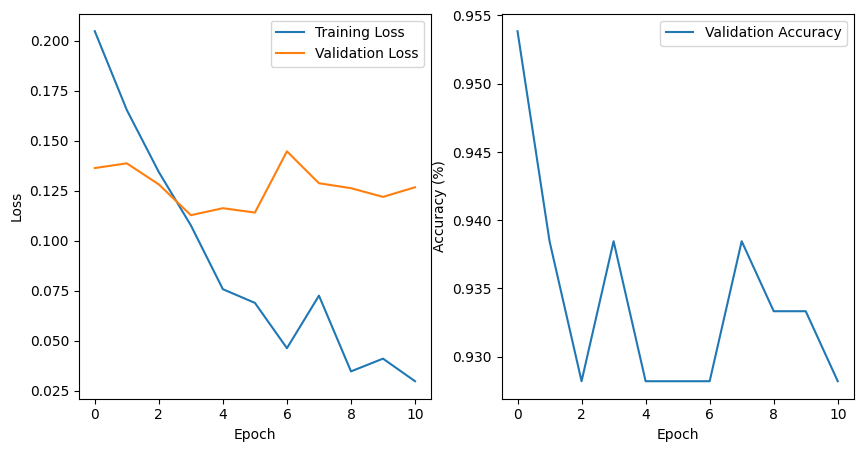

In [68]:
# Plotting training and validation metrics
plt.figure(figsize = (10, 5))

plt.subplot(1, 2, 1)
plt.plot(MODEL_RESULTS["train_loss"], label = 'Training Loss')
plt.plot(MODEL_RESULTS["test_loss"], label = 'Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(MODEL_RESULTS["test_accuracy"], label = 'Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()

plt.show()

# Accuracy, and Evaluation

Model evaluation was performed on a dedicated test set to assess the model's ability to generalize to unseen data. The key evaluation metrics included:

*   **Confusion Matrix:** This provided a detailed breakdown of the model's predictions, showing true positives (correctly identified real images), true negatives (correctly identified AI-generated images), false positives (AI-generated images incorrectly classified as real), and false negatives (real images incorrectly classified as AI-generated).
*   **Classification Report:** This report offered precision, recall, and F1-score for each class, providing insights into the model's performance in identifying each category.
*   **Overall Accuracy:** The model achieved an overall accuracy of approximately 93.85% on the test set, indicating its strong capability in correctly classifying images.

The evaluation results suggest that the model performs well in distinguishing between AI-generated and real images, with a good balance between precision and recall for both classes. The relatively high overall accuracy demonstrates the effectiveness of the chosen approach and the fine-tuning process.

## Confusion Matrix

The confusion matrix provides a visual summary of the model's performance on the validation dataset. It shows the counts of true positive, true negative, false positive, and false negative predictions. In this matrix:

*   The rows represent the true labels (the actual classes of the images).
*   The columns represent the predicted labels (the classes the model predicted).
*   The diagonal elements (top-left and bottom-right) show the number of correct predictions (True Negatives and True Positives).
*   The off-diagonal elements (top-right and bottom-left) show the number of incorrect predictions (False Positives and False Negatives).

Specifically, for this binary classification task (AI-generated vs. Real), the confusion matrix helps us understand:

*   How many AI-generated images were correctly identified as AI-generated (True Negatives).
*   How many real images were correctly identified as real (True Positives).
*   How many AI-generated images were incorrectly classified as real (False Positives).
*   How many real images were incorrectly classified as AI-generated (False Negatives).

Analyzing the values in the confusion matrix, along with metrics like precision, recall, and F1-score derived from it, provides a deeper understanding of the model's strengths and weaknesses in classifying each category.

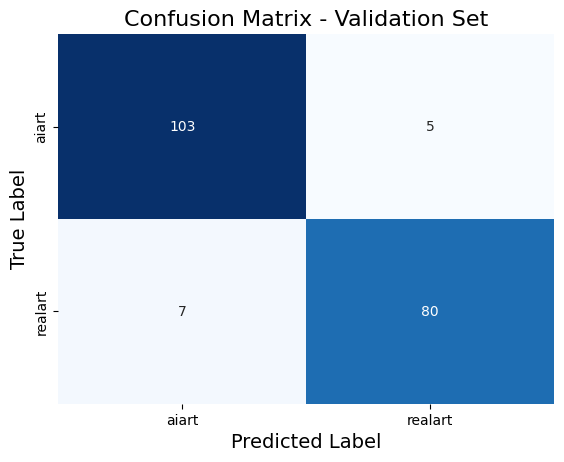

In [70]:
# Plotting confusion matrix for validation data
model.eval()
allLabels = []
allPreds = []

valLoader = test_loader
with torch.no_grad():
    for inputs, labels in valLoader:
        inputs, labels = inputs.to(device), labels.to(device)
        labels = labels.unsqueeze(1).float()

        outputs = model(inputs)
        predictions = (torch.sigmoid(outputs) > 0.5).float()

        allLabels.extend(labels.cpu().numpy())
        allPreds.extend(predictions.cpu().numpy())

allLabels = np.array(allLabels)
allPreds = np.array(allPreds)

matrix = confusion_matrix(allLabels, allPreds)

classes = ['aiart', 'realart']  # Define your classes manually
sns.heatmap(matrix, annot = True, fmt = 'd', cmap = 'Blues', xticklabels = classes, yticklabels = classes, cbar = False)
plt.title('Confusion Matrix - Validation Set', fontsize = 16)
plt.xlabel('Predicted Label', fontsize = 14)
plt.ylabel('True Label', fontsize = 14)
plt.show()

In [71]:
from sklearn.metrics import classification_report, accuracy_score

# Ensure the model is in evaluation mode
model.eval()

all_labels = []
all_preds = []

# No need to track gradients for evaluation
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        # Get model outputs (logits)
        outputs = model(inputs)

        # Convert logits to probabilities and then to binary predictions (0 or 1)
        predictions = (torch.sigmoid(outputs) > 0.5).float()

        # Append batch results to the lists (move them to CPU)
        all_labels.extend(labels.cpu().numpy())
        all_preds.extend(predictions.cpu().numpy())

# Generate and print the classification report
# Class 0: AI-generated, Class 1: Real
target_names = ['AI-generated (0)', 'Real (1)']
print("--- Classification Report ---")
print(classification_report(all_labels, all_preds, target_names=target_names))

# You can also print the overall accuracy separately
accuracy = accuracy_score(all_labels, all_preds)
print(f"Overall Accuracy: {accuracy:.4f}")

--- Classification Report ---
                  precision    recall  f1-score   support

AI-generated (0)       0.94      0.95      0.94       108
        Real (1)       0.94      0.92      0.93        87

        accuracy                           0.94       195
       macro avg       0.94      0.94      0.94       195
    weighted avg       0.94      0.94      0.94       195

Overall Accuracy: 0.9385



--- Visualizing Input Image and its Corresponding Feature Maps ---


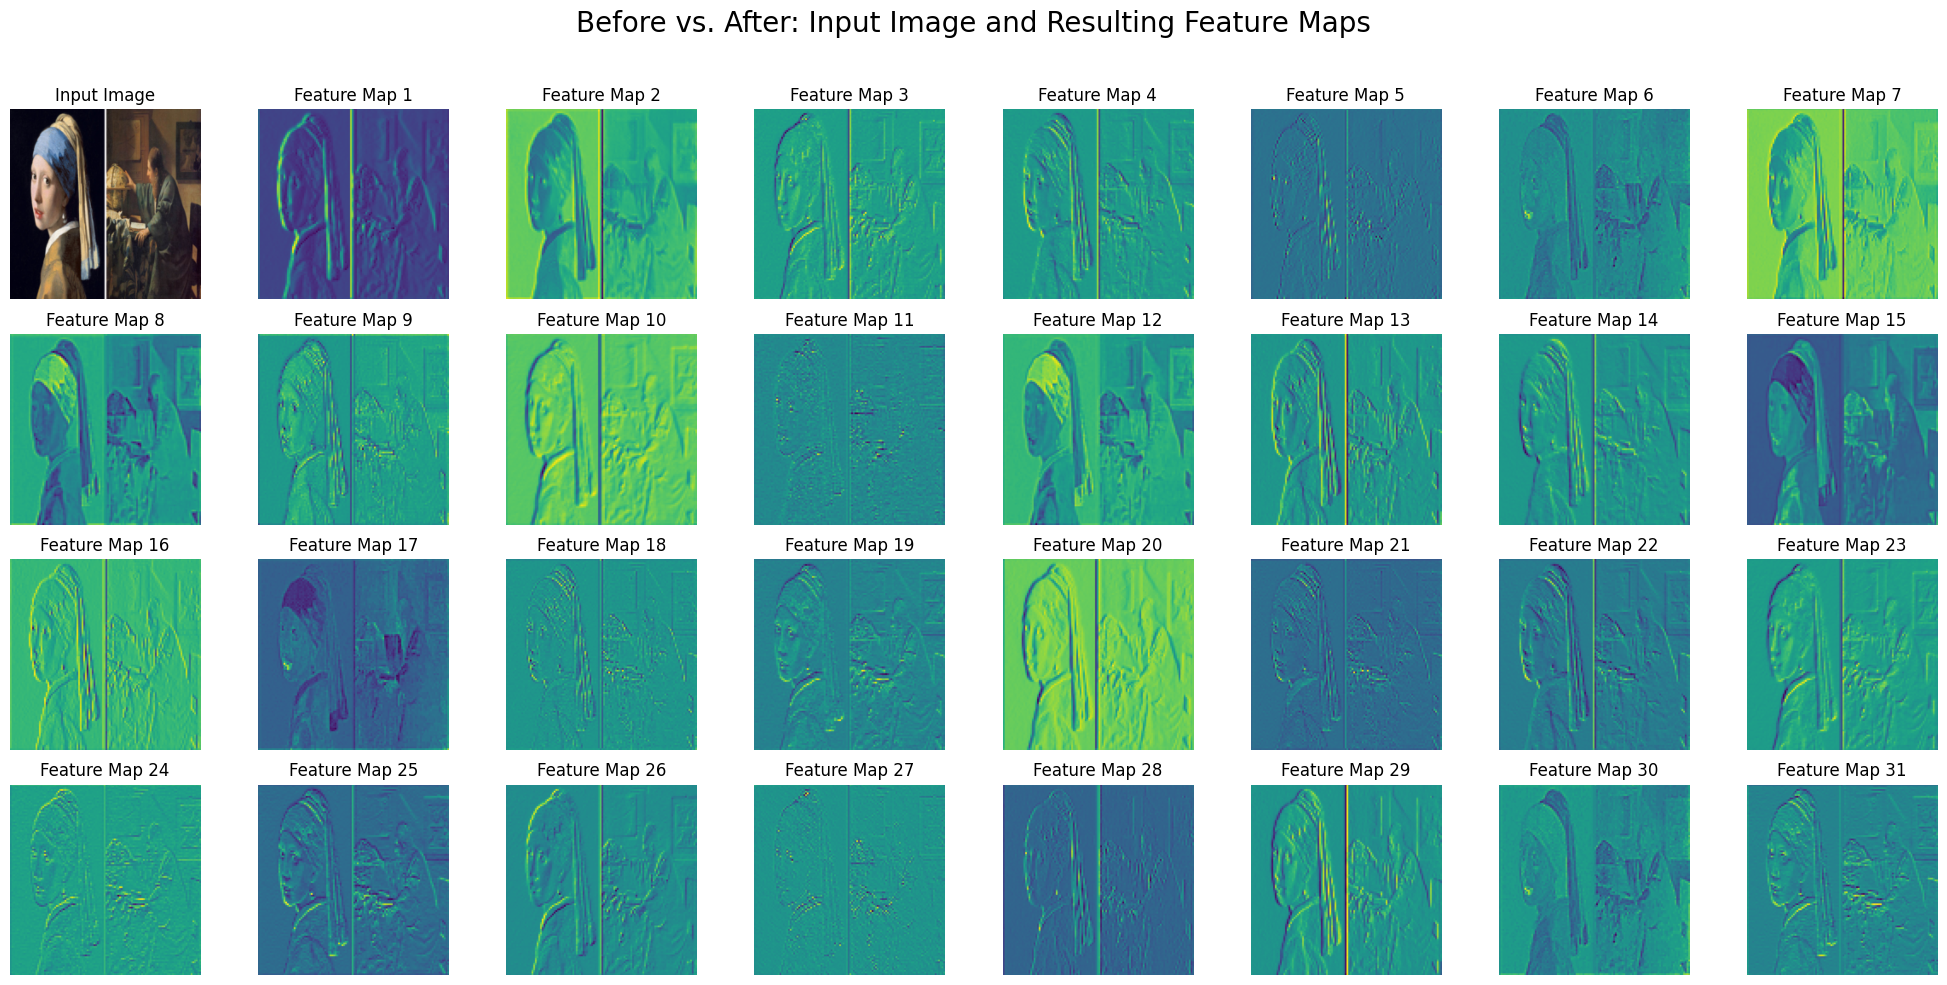

In [69]:
# =============================================================================
# Visualizing Input Image and its Feature Maps Together
# =============================================================================

print("\n--- Visualizing Input Image and its Corresponding Feature Maps ---")

# --- 1. Setup the Hook ---
# Make sure your model is trained and the hook is pointing to the correct layer
# For EfficientNet:
target_layer = model.features[2][0].block[0][0]
# For ResNet18:
# target_layer = model.layer1[0].conv1

activation = {}
def get_activation(name):
    def hook(model, input, output):
        activation[name] = output.detach()
    return hook

target_layer.register_forward_hook(get_activation('feature_maps'))


# --- 2. Get an Image and Pass it Through the Model ---
dataiter = iter(test_loader)
images, labels = next(dataiter)
# Select the first image from the batch
img_to_viz = images[0].unsqueeze(0).to(device)

# Pass the image through the model to trigger the hook
_ = model(img_to_viz)

# Retrieve the feature maps
feature_maps = activation['feature_maps'].squeeze().cpu()


# --- 3. Plot Everything Together ---
# Create a figure that is wide enough
plt.figure(figsize=(20, 10))

# --- Plot the original image in the first subplot ---
ax = plt.subplot(4, 8, 1) # Display on a 4x8 grid, in the 1st position
ax.set_title("Input Image")

# Un-normalize the image tensor for proper viewing
mean = np.array([0.485, 0.456, 0.406])
std = np.array([0.229, 0.224, 0.225])
img_for_display = img_to_viz.cpu().squeeze(0).permute(1, 2, 0).numpy()
img_for_display = std * img_for_display + mean
img_for_display = np.clip(img_for_display, 0, 1)
ax.imshow(img_for_display)
ax.axis('off')

# --- Plot the feature maps in the remaining subplots ---
for i, feature_map in enumerate(feature_maps):
    # Don't plot more maps than we have space for, and skip the first spot
    if i >= (4 * 8) - 1:
        break
    ax = plt.subplot(4, 8, i + 2) # Start plotting from the 2nd position
    ax.set_title(f"Feature Map {i+1}")
    ax.imshow(feature_map, cmap='viridis')
    ax.axis('off')

plt.suptitle("Before vs. After: Input Image and Resulting Feature Maps", fontsize=20)
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

# Model Saving and Loading

To make the trained model reusable, its state dictionary (containing the learned parameters) was saved to a file using `torch.save()`. This allows the model to be loaded later without needing to retrain it. A separate process was demonstrated to load the saved model. This involves re-creating the exact same model architecture as the one that was trained, loading the saved state dictionary into this new architecture using `torch.load()`, and then setting the model to evaluation mode (`model.eval()`) which is crucial for inference as it disables dropout and adjusts batch normalization. The loaded model is then ready to make predictions on new images.

### Save Model

In [64]:
# Define a path and filename for your saved model
MODEL_SAVE_PATH = "efficientnet_b0_image_classifier.pth"

# Save the model's state dictionary
# We save the state_dict() which contains all the learned weights and biases
torch.save(model.state_dict(), MODEL_SAVE_PATH)

print(f"Model saved successfully to: {MODEL_SAVE_PATH}")

Model saved successfully to: efficientnet_b0_image_classifier.pth


### Load Model

In [48]:
import torch
import torch.nn as nn
from torchvision import models

# 1. Re-create the model architecture
# It must be the exact same architecture as the one you saved (e.g., efficientnet_b0)
loaded_model = models.efficientnet_b0()

# 2. Modify the classifier to match your saved model's structure
num_features = loaded_model.classifier[1].in_features
loaded_model.classifier[1] = nn.Linear(num_features, 1) # Must match the output of your trained model

# 3. Define the path to your saved model
MODEL_SAVE_PATH = "efficientnet_b0_image_classifier.pth"

# 4. Load the state dictionary into the model architecture
loaded_model.load_state_dict(torch.load(MODEL_SAVE_PATH))

# 5. Set the device and put the model in evaluation mode
device = "cuda" if torch.cuda.is_available() else "cpu"
loaded_model.to(device)

# VERY IMPORTANT: This turns off layers like dropout and batch normalization,
# which are only used during training.
loaded_model.eval()

print("Model has been loaded and is ready for inference!")

Model has been loaded and is ready for inference!


# Evluate Using Different Images

In [78]:
import torch
import torch.nn as nn
from torchvision import models, transforms
from PIL import Image

# --- Step 1: Load Your Trained Model ---

# Set the device
device = "cuda" if torch.cuda.is_available() else "cpu"

# Re-create the model architecture (must be the same as when you trained)
model = models.efficientnet_b0()
model.classifier[1] = nn.Linear(in_features=1280, out_features=1)

# Load the saved weights into the model
MODEL_SAVE_PATH = "efficientnet_b0_image_classifier.pth"
model.load_state_dict(torch.load(MODEL_SAVE_PATH))

# Move model to the device
model.to(device)

# Set the model to evaluation mode (very important!)
model.eval()


# --- Step 2: Prepare Your New Image ---

# The transformations must be IDENTICAL to the test_transform from your training script
img_size = 224
image_transform = transforms.Compose([
    transforms.Resize((img_size, img_size)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Provide the path to your new image
image_path = '/content/pxel.jpg' # <--- CHANGE THIS PATH

try:
    # Open the image and convert to RGB
    image = Image.open(image_path).convert("RGB")

    # Apply the transformations
    transformed_image = image_transform(image)

    # Add a batch dimension (the model expects a batch of images, not a single one)
    # The shape changes from [3, 224, 224] to [1, 3, 224, 224]
    image_batch = transformed_image.unsqueeze(0).to(device)


    # --- Step 3: Make and Interpret the Prediction ---

    with torch.no_grad(): # Turn off gradient tracking
        # Get the raw output (logit) from the model
        output_logit = model(image_batch)

        # Convert the logit to a probability using the sigmoid function
        output_prob = torch.sigmoid(output_logit)

    # Get the predicted label by checking if the probability is > 0.5
    predicted_label = (output_prob > 0.5).item()

    # Get the confidence score
    confidence = output_prob.item() if predicted_label == 1 else 1 - output_prob.item()

    # Print the result
    if predicted_label == 1:
        print(f"Prediction: This is a REAL image (Confidence: {confidence:.2%})")
    else:
        print(f"Prediction: This is an AI-GENERATED image (Confidence: {confidence:.2%})")

except FileNotFoundError:
    print(f"Error: The file was not found at '{image_path}'. Please check the path and try again.")

Prediction: This is a REAL image (Confidence: 99.23%)


# Grad-CAM Visualization

Grad-CAM (Gradient-weighted Class Activation Mapping) was used as an Explainable AI (XAI) technique to understand which parts of an image are most important for the model's prediction. By targeting the last convolutional layer of the model, Grad-CAM generates a heatmap that highlights the regions in the input image that contribute most to the predicted class score. This heatmap is then overlaid on the original image. The visualization shows which visual features the model is focusing on when deciding if an image is AI-generated or real, providing insights into the model's decision-making process. This helps in verifying if the model is learning relevant features and can aid in debugging or improving the model.

In [73]:
pip install grad-cam

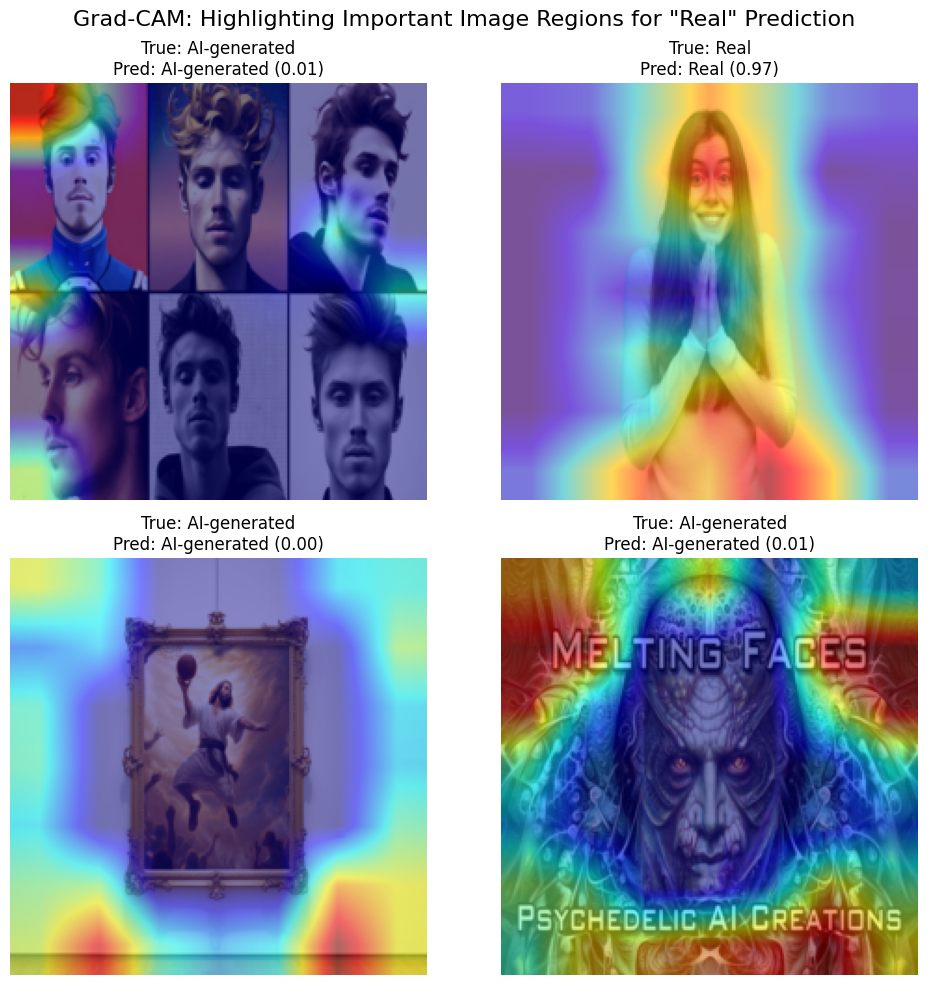

In [74]:
import cv2
import numpy as np
import torch
from torchvision import models, transforms
from PIL import Image
import matplotlib.pyplot as plt

from pytorch_grad_cam.utils.image import show_cam_on_image, preprocess_image
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget

# --- 1. Load your trained model (same as before) ---
device = "cuda" if torch.cuda.is_available() else "cpu"
model = models.efficientnet_b0()
model.classifier[1] = nn.Linear(in_features=1280, out_features=1)
MODEL_SAVE_PATH = "efficientnet_b0_image_classifier.pth"
model.load_state_dict(torch.load(MODEL_SAVE_PATH, map_location=torch.device(device)))
model.to(device)
model.eval()

# --- 2. Select the target layer for Grad-CAM ---
# The last convolutional layer is a good choice
target_layer = model.features[-1]

# --- 3. Prepare images and transformations for visualization ---
# We need a transform without normalization to see the original image clearly
vis_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])

# Create a dataset for visualization (using your test data)
vis_dataset = CustomImageDataset(test_data_df, transform=vis_transform)
vis_loader = DataLoader(vis_dataset, batch_size=4, shuffle=True) # Get a small batch

# --- 4. Generate and display Grad-CAM heatmaps ---
cam = GradCAM(model=model, target_layers=[target_layer])

# Get a batch of images
images, labels = next(iter(vis_loader))
images = images.to(device)

# The model was trained on normalized images, so we still need the normalized version for prediction
normalized_transform = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
input_tensor = normalized_transform(images)

# Define the target for binary classification (we want to see why it predicted "1" or "0")
targets = [ClassifierOutputTarget(0) for label in labels] # See why it thinks "Real"

# Generate the grayscale CAM
grayscale_cam = cam(input_tensor=input_tensor, targets=targets)

# Plot the results
fig, axes = plt.subplots(2, 2, figsize=(10, 10))
fig.suptitle('Grad-CAM: Highlighting Important Image Regions for "Real" Prediction', fontsize=16)

class_names = ['AI-generated', 'Real']

for i, ax in enumerate(axes.flat):
    # Convert single image tensor back to NumPy for visualization
    rgb_img = images[i].permute(1, 2, 0).cpu().numpy()

    # Overlay the CAM on the image
    visualization = show_cam_on_image(rgb_img, grayscale_cam[i, :], use_rgb=True)

    # Get model prediction for this image
    with torch.no_grad():
        pred_prob = torch.sigmoid(model(input_tensor[i].unsqueeze(0))).item()
        pred_label = 1 if pred_prob > 0.5 else 0

    ax.imshow(visualization)
    ax.set_title(f"True: {class_names[labels[i]]}\nPred: {class_names[pred_label]} ({pred_prob:.2f})")
    ax.axis('off')

plt.tight_layout()
plt.show()